In [119]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import io

### Prep dataset

In [ ]:
#get handwritten text dataset from hugging face
splits = {'train': 'data/train.parquet', 'validation': 'data/validation.parquet', 'test': 'data/test.parquet'}
df_train = pd.read_parquet("hf://datasets/Teklia/IAM-line/" + splits["train"])
df_val = pd.read_parquet("hf://datasets/Teklia/IAM-line/" + splits["validation"])
df_test = pd.read_parquet("hf://datasets/Teklia/IAM-line/" + splits["test"])

df_train.shape, df_val.shape, df_test.shape

In [65]:
charset = sorted(list(set(''.join(df_train['text'].tolist() + df_val['text'].tolist() + df_test['text'].tolist()))))

print('# of unique characters: ', len(charset))

idx_to_char = dict(list(enumerate(charset)))
char_to_idx = dict([(idx_to_char[k], k) for k in idx_to_char.keys()])

def encode(text) -> np.array:
    return np.array([char_to_idx[ch] for ch in text])

def decode(arr) -> str:
    return ''.join([idx_to_char[ch] for ch in arr])

# of unique characters:  79


In [66]:
encode('hello'), decode(encode('hello'))

(array([60, 57, 64, 64, 67]), 'hello')

In [134]:
def sample(df, n):
    samp_df = df.sample(n)
    img_arrays = samp_df['image'].apply(lambda x: x['bytes']).apply(lambda x: np.array(Image.open(io.BytesIO(x)))).tolist()
    img_texts = samp_df['text'].tolist()
    img_texts_encoded = samp_df['text'].apply(encode).tolist()
    return list(zip(img_arrays, img_texts, img_texts_encoded))

for retirement , their wages paid for the time thus spent . An


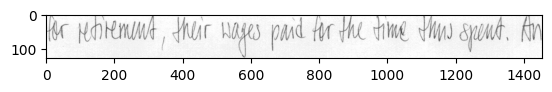

In [142]:
s = sample(df_train, 10)
print(s[0][1])
plt.imshow(s[0][0], cmap='gray')

### Using simple RNN + CTC

In [128]:
#init params

INPUT_SIZE = 128
OUTPUT_PROB_SIZE = len(charset) #79
HIDDEN_SIZE = 60

#weights applied to x input, [128 x 1]/[1 x 128] @ [128 x 20]--> [1 x 20]
Wx = torch.randn((INPUT_SIZE, HIDDEN_SIZE)) / INPUT_SIZE**0.5

#weights applied to prev hidden layer, [1 x 20] @ [20 x 20] --> [1 x 20]
Wh = torch.randn((HIDDEN_SIZE, HIDDEN_SIZE)) / HIDDEN_SIZE**0.5
bh = torch.randn(HIDDEN_SIZE) #bias 20 dim

#weights to generate output probabilities from combined inputs [1 x 20] @ [20 x output size] --> [1 x output size]
Wp = torch.randn((HIDDEN_SIZE, OUTPUT_PROB_SIZE))


In [143]:
#feed forward

#normalize input and cast to torch tensor
x = (torch.Tensor(s[0][0]) - s[0][0].mean()) / s[0][0].var()
out_prob = []
for i in range(x.shape[1]):
    if i == 0:
        h_t = x[:, i] @ Wx + bh
    else:
        h_t = x[:, i] @ Wx + h_t @ Wh + bh
    h_t = torch.sigmoid(h_t)
    logits = h_t @ Wp
    probs = F.softmax(logits, dim=0)
    out_prob.append(probs)

In [144]:
#compute loss with CTC

s[0]


(array([[255, 255, 255, ..., 248, 250, 250],
        [254, 254, 254, ..., 252, 253, 253],
        [253, 253, 253, ..., 252, 253, 253],
        ...,
        [244, 246, 249, ..., 255, 254, 253],
        [244, 248, 253, ..., 255, 255, 254],
        [242, 247, 253, ..., 252, 253, 253]],
       shape=(128, 1454), dtype=uint8),
 'for retirement , their wages paid for the time thus spent . An',
 array([58, 67, 70,  0, 70, 57, 72, 61, 70, 57, 65, 57, 66, 72,  0, 10,  0,
        72, 60, 57, 61, 70,  0, 75, 53, 59, 57, 71,  0, 68, 53, 61, 56,  0,
        58, 67, 70,  0, 72, 60, 57,  0, 72, 61, 65, 57,  0, 72, 60, 73, 71,
         0, 71, 68, 57, 66, 72,  0, 12,  0, 27, 66]))